
# XGBoost for Fraud Detection



In [1]:
%cd /content/drive/MyDrive/credit risk

/content/drive/MyDrive/credit risk


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Load Data

In [18]:
credit_card = pd.read_csv('credit_card_transactions.csv')

In [11]:
credit_card.head(10).to_csv('credit_card_transactions_head_10.csv')

In [19]:
credit_card

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,merch_zipcode
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,28705.0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,NaN
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,83236.0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,NaN
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,22844.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1296670,1296670,2020-06-21 12:12:08,30263540414123,fraud_Reichel Inc,entertainment,15.56,Erik,Patterson,M,162 Jessica Row Apt. 072,...,-112.4777,258,Geoscientist,1961-11-24,440b587732da4dc1a6395aba5fb41669,1371816728,36.841266,-111.690765,0,NaN
1296671,1296671,2020-06-21 12:12:19,6011149206456997,fraud_Abernathy and Sons,food_dining,51.70,Jeffrey,White,M,8617 Holmes Terrace Suite 651,...,-77.5101,100,"Production assistant, television",1979-12-11,278000d2e0d2277d1de2f890067dcc0a,1371816739,38.906881,-78.246528,0,22630.0
1296672,1296672,2020-06-21 12:12:32,3514865930894695,fraud_Stiedemann Ltd,food_dining,105.93,Christopher,Castaneda,M,1632 Cohen Drive Suite 639,...,-105.8189,899,Naval architect,1967-08-30,483f52fe67fabef353d552c1e662974c,1371816752,33.619513,-105.130529,0,88351.0
1296673,1296673,2020-06-21 12:13:36,2720012583106919,"fraud_Reinger, Weissnat and Strosin",food_dining,74.90,Joseph,Murray,M,42933 Ryan Underpass,...,-102.5411,1126,Volunteer coordinator,1980-08-18,d667cdcbadaaed3da3f4020e83591c83,1371816816,42.788940,-103.241160,0,69367.0


In [13]:
credit_card.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 24 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Unnamed: 0             1296675 non-null  int64  
 1   trans_date_trans_time  1296675 non-null  object 
 2   cc_num                 1296675 non-null  int64  
 3   merchant               1296675 non-null  object 
 4   category               1296675 non-null  object 
 5   amt                    1296675 non-null  float64
 6   first                  1296675 non-null  object 
 7   last                   1296675 non-null  object 
 8   gender                 1296675 non-null  object 
 9   street                 1296675 non-null  object 
 10  city                   1296675 non-null  object 
 11  state                  1296675 non-null  object 
 12  zip                    1296675 non-null  int64  
 13  lat                    1296675 non-null  float64
 14  long              

## Feature Engineering

In [21]:
credit_card['distance_between_cust_merch'] = np.sqrt((credit_card['lat'] - credit_card['merch_lat'])**2 + (credit_card['long'] - credit_card['merch_long'])**2)

In [22]:
credit_card['distance_between_cust_merch']

,distance_between_cust_merch
0,0.872830
1,0.272310
2,0.975845
3,0.919802
4,0.868505
...,...
1296670,1.177732
1296671,0.819632
1296672,0.967541
1296673,0.898775


In [23]:


def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # km
    dlat = np.radians(lat2 - lat1)
    dlon = np.radians(lon2 - lon1)
    a = np.sin(dlat/2)**2 + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.sin(dlon/2)**2
    return 2 * R * np.arcsin(np.sqrt(a))

credit_card['haversine_distance_km'] = haversine(
    credit_card['lat'], credit_card['long'],
    credit_card['merch_lat'], credit_card['merch_long']
)

In [24]:
credit_card['haversine_distance_km']

,haversine_distance_km
0,78.597568
1,30.212176
2,108.206083
3,95.673231
4,77.556744
...,...
1296670,119.752136
1296671,75.104085
1296672,99.047734
1296673,84.627652


In [25]:
import re

In [26]:
credit_card['trans_date_trans_time']

,trans_date_trans_time
0,2019-01-01 00:00:18
1,2019-01-01 00:00:44
2,2019-01-01 00:00:51
3,2019-01-01 00:01:16
4,2019-01-01 00:03:06
...,...
1296670,2020-06-21 12:12:08
1296671,2020-06-21 12:12:19
1296672,2020-06-21 12:12:32
1296673,2020-06-21 12:13:36


In [30]:
credit_card['trans_date_trans_time'] = pd.to_datetime(credit_card['trans_date_trans_time'])

credit_card['date'] = credit_card['trans_date_trans_time'].dt.date
credit_card['time'] = credit_card['trans_date_trans_time'].dt.time
credit_card['hour'] = credit_card['trans_date_trans_time'].dt.hour
credit_card['minute'] = credit_card['trans_date_trans_time'].dt.minute

In [32]:
credit_card['seconds'] = credit_card['trans_date_trans_time'].dt.second

In [33]:
credit_card

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,merch_long,is_fraud,merch_zipcode,distance_between_cust_merch,haversine_distance_km,date,time,hour,minute,seconds
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,-82.048315,0,28705.0,0.872830,78.597568,2019-01-01,00:00:18,0,0,18
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,-118.186462,0,NaN,0.272310,30.212176,2019-01-01,00:00:44,0,0,44
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,-112.154481,0,83236.0,0.975845,108.206083,2019-01-01,00:00:51,0,0,51
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,-112.561071,0,NaN,0.919802,95.673231,2019-01-01,00:01:16,0,1,16
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,-78.632459,0,22844.0,0.868505,77.556744,2019-01-01,00:03:06,0,3,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1296670,1296670,2020-06-21 12:12:08,30263540414123,fraud_Reichel Inc,entertainment,15.56,Erik,Patterson,M,162 Jessica Row Apt. 072,...,-111.690765,0,NaN,1.177732,119.752136,2020-06-21,12:12:08,12,12,8
1296671,1296671,2020-06-21 12:12:19,6011149206456997,fraud_Abernathy and Sons,food_dining,51.70,Jeffrey,White,M,8617 Holmes Terrace Suite 651,...,-78.246528,0,22630.0,0.819632,75.104085,2020-06-21,12:12:19,12,12,19
1296672,1296672,2020-06-21 12:12:32,3514865930894695,fraud_Stiedemann Ltd,food_dining,105.93,Christopher,Castaneda,M,1632 Cohen Drive Suite 639,...,-105.130529,0,88351.0,0.967541,99.047734,2020-06-21,12:12:32,12,12,32
1296673,1296673,2020-06-21 12:13:36,2720012583106919,"fraud_Reinger, Weissnat and Strosin",food_dining,74.90,Joseph,Murray,M,42933 Ryan Underpass,...,-103.241160,0,69367.0,0.898775,84.627652,2020-06-21,12:13:36,12,13,36


In [28]:
re.split('\\d+-\\d+-\\d\\d', credit_card['trans_date_trans_time'][0])

['', ' 00:00:18']

In [29]:
re.split('\\d+:\\d+:\\d\\d', credit_card['trans_date_trans_time'][0])

['2019-01-01 ', '']

In [34]:
credit_card['rolling_avg_amt_10'] = (
    credit_card.groupby('cc_num')['amt']
    .rolling(window=10)
    .mean()
    .reset_index(level=0, drop=True)
)

In [35]:
credit_card['rolling_avg_amt_10']

,rolling_avg_amt_10
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
...,...
1296670,58.126
1296671,88.055
1296672,48.469
1296673,85.921


In [36]:
credit_card['time_diff'] = (
    credit_card.groupby('cc_num')['trans_date_trans_time']
    .diff()
    .dt.total_seconds()
)

In [37]:
credit_card['rolling_std_amt_10'] = (
    credit_card.groupby('cc_num')['amt']
    .rolling(10)
    .std()
    .reset_index(level=0, drop=True)
)

In [39]:
credit_card['day_of_week'] = credit_card['trans_date_trans_time'].dt.day_of_week


credit_card['weekend'] = credit_card['trans_date_trans_time'].dt.weekday >= 5

In [40]:
credit_card

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,date,time,hour,minute,seconds,rolling_avg_amt_10,time_diff,rolling_std_amt_10,day_of_week,weekend
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,2019-01-01,00:00:18,0,0,18,NaN,NaN,NaN,1,False
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,2019-01-01,00:00:44,0,0,44,NaN,NaN,NaN,1,False
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,2019-01-01,00:00:51,0,0,51,NaN,NaN,NaN,1,False
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,2019-01-01,00:01:16,0,1,16,NaN,NaN,NaN,1,False
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,2019-01-01,00:03:06,0,3,6,NaN,NaN,NaN,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1296670,1296670,2020-06-21 12:12:08,30263540414123,fraud_Reichel Inc,entertainment,15.56,Erik,Patterson,M,162 Jessica Row Apt. 072,...,2020-06-21,12:12:08,12,12,8,58.126,16781.0,49.121658,6,True
1296671,1296671,2020-06-21 12:12:19,6011149206456997,fraud_Abernathy and Sons,food_dining,51.70,Jeffrey,White,M,8617 Holmes Terrace Suite 651,...,2020-06-21,12:12:19,12,12,19,88.055,7962.0,32.523777,6,True
1296672,1296672,2020-06-21 12:12:32,3514865930894695,fraud_Stiedemann Ltd,food_dining,105.93,Christopher,Castaneda,M,1632 Cohen Drive Suite 639,...,2020-06-21,12:12:32,12,12,32,48.469,29074.0,44.382856,6,True
1296673,1296673,2020-06-21 12:13:36,2720012583106919,"fraud_Reinger, Weissnat and Strosin",food_dining,74.90,Joseph,Murray,M,42933 Ryan Underpass,...,2020-06-21,12:13:36,12,13,36,85.921,91018.0,23.128574,6,True


In [45]:
credit_card['night_time'] = ((credit_card['trans_date_trans_time'].dt.hour < 6) | (credit_card['trans_date_trans_time'].dt.hour > 20))

In [46]:
credit_card

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,time,hour,minute,seconds,rolling_avg_amt_10,time_diff,rolling_std_amt_10,day_of_week,weekend,night_time
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,00:00:18,0,0,18,NaN,NaN,NaN,1,False,True
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,00:00:44,0,0,44,NaN,NaN,NaN,1,False,True
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,00:00:51,0,0,51,NaN,NaN,NaN,1,False,True
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,00:01:16,0,1,16,NaN,NaN,NaN,1,False,True
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,00:03:06,0,3,6,NaN,NaN,NaN,1,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1296670,1296670,2020-06-21 12:12:08,30263540414123,fraud_Reichel Inc,entertainment,15.56,Erik,Patterson,M,162 Jessica Row Apt. 072,...,12:12:08,12,12,8,58.126,16781.0,49.121658,6,True,False
1296671,1296671,2020-06-21 12:12:19,6011149206456997,fraud_Abernathy and Sons,food_dining,51.70,Jeffrey,White,M,8617 Holmes Terrace Suite 651,...,12:12:19,12,12,19,88.055,7962.0,32.523777,6,True,False
1296672,1296672,2020-06-21 12:12:32,3514865930894695,fraud_Stiedemann Ltd,food_dining,105.93,Christopher,Castaneda,M,1632 Cohen Drive Suite 639,...,12:12:32,12,12,32,48.469,29074.0,44.382856,6,True,False
1296673,1296673,2020-06-21 12:13:36,2720012583106919,"fraud_Reinger, Weissnat and Strosin",food_dining,74.90,Joseph,Murray,M,42933 Ryan Underpass,...,12:13:36,12,13,36,85.921,91018.0,23.128574,6,True,False


In [47]:
def part_of_day(h):
    if 5 <= h < 12:
        return 'morning'
    elif 12 <= h < 17:
        return 'afternoon'
    elif 17 <= h < 21:
        return 'evening'
    else:
        return 'night'

credit_card['part_of_day'] = credit_card['hour'].apply(part_of_day)

In [48]:
credit_card = credit_card.sort_values(['cc_num', 'trans_date_trans_time'])

credit_card['time_since_last_txn'] = (
    credit_card.groupby('cc_num')['trans_date_trans_time']
    .diff()
    .dt.total_seconds()
)

In [52]:



txn_count = (
    credit_card
    .groupby('cc_num')
    .rolling('24h', on='trans_date_trans_time')['trans_num']
    .count()
    .reset_index()
)
credit_card['txn_count_24h'] = txn_count['trans_num'].values


In [54]:
import holidays
us_holidays = holidays.US()

credit_card['is_holiday'] = credit_card['trans_date_trans_time'].dt.date.astype('datetime64[ns]').isin(us_holidays)

In [55]:
credit_card['merchant_freq'] = (
    credit_card.groupby(['cc_num', 'merchant'])['trans_num']
    .transform('count')
)

In [58]:
credit_card['distance_anomaly'] = (
    credit_card['distance_between_cust_merch'] /
    credit_card.groupby('cc_num')['distance_between_cust_merch'].transform('median')
)

In [59]:
merchant_fraud_rate = (
    credit_card.groupby('merchant')['is_fraud']
    .mean()
    .rename('merchant_fraud_rate')
)

credit_card = credit_card.join(merchant_fraud_rate, on='merchant')

In [60]:
category_fraud_rate = (
    credit_card.groupby('category')['is_fraud']
    .mean()
    .rename('category_fraud_rate')
)

credit_card = credit_card.join(category_fraud_rate, on='category')

In [61]:
credit_card['cust_merchant_freq'] = (
    credit_card.groupby(['cc_num', 'merchant'])['trans_num']
    .transform('count')
)

In [62]:
credit_card['merchant_global_freq'] = (
    credit_card.groupby('merchant')['trans_num']
    .transform('count')
)

In [63]:
credit_card['cust_merchant_diversity'] = (
    credit_card.groupby('cc_num')['merchant']
    .transform('nunique')
)

In [64]:
credit_card['cust_category_diversity'] = (
    credit_card.groupby('cc_num')['category']
    .transform('nunique')
)

In [66]:
credit_card = credit_card.sort_values(['cc_num', 'trans_date_trans_time'])

credit_card['time_since_merchant'] = (
    credit_card.groupby(['cc_num', 'merchant'])['trans_date_trans_time']
    .diff()
    .dt.total_seconds()
)

In [68]:
credit_card.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1296675 entries, 1017 to 1296427
Data columns (total 50 columns):
 #   Column                       Non-Null Count    Dtype         
---  ------                       --------------    -----         
 0   Unnamed: 0                   1296675 non-null  int64         
 1   trans_date_trans_time        1296675 non-null  datetime64[ns]
 2   cc_num                       1296675 non-null  int64         
 3   merchant                     1296675 non-null  object        
 4   category                     1296675 non-null  object        
 5   amt                          1296675 non-null  float64       
 6   first                        1296675 non-null  object        
 7   last                         1296675 non-null  object        
 8   gender                       1296675 non-null  object        
 9   street                       1296675 non-null  object        
 10  city                         1296675 non-null  object        
 11  state        

In [82]:
encode = [
    'is_holiday',
    'part_of_day',
    'night_time',
    'weekend',
]

In [94]:
credit_card['part_of_day'] = credit_card['part_of_day'].astype('category').cat.codes

In [91]:
credit_card['night_time'] = credit_card['night_time'].astype(int)

In [90]:
credit_card['is_holiday'] =credit_card['is_holiday'].astype(int)

In [96]:
credit_card['weekend'] = credit_card['weekend'].astype(int)

In [99]:
credit_card['rolling_avg_amt_10'] = (
    credit_card.groupby('cc_num')['rolling_avg_amt_10']
    .transform(lambda x: x.fillna(x.median()))
)

credit_card['rolling_std_amt_10'] = (
    credit_card.groupby('cc_num')['rolling_std_amt_10']
    .transform(lambda x: x.fillna(x.median()))
)

credit_card['time_since_last_txn'] = (
    credit_card.groupby('cc_num')['time_since_last_txn']
    .transform(lambda x: x.fillna(x.median()))
)

credit_card['time_since_merchant'] = (
    credit_card.groupby(['cc_num', 'merchant'])['time_since_merchant']
    .transform(lambda x: x.fillna(x.median()))
)

In [100]:
global_fraud_rate = credit_card['is_fraud'].mean()

credit_card['merchant_fraud_rate'] = (
    credit_card['merchant_fraud_rate']
    .fillna(global_fraud_rate)
)

credit_card['category_fraud_rate'] = (
    credit_card['category_fraud_rate']
    .fillna(global_fraud_rate)
)

count_features = [
    'txn_count_24h',
    'cust_merchant_freq',
    'merchant_global_freq',
    'cust_merchant_diversity',
    'cust_category_diversity'
]

for col in count_features:
    credit_card[col] = credit_card[col].fillna(0)

In [101]:
credit_card['distance_anomaly'] = (
    credit_card.groupby('cc_num')['distance_anomaly']
    .transform(lambda x: x.fillna(x.median()))
)

In [102]:
features = [
    'amt',
    'night_time',
    'weekend',
    'txn_count_24h',
    'time_since_last_txn',
    'rolling_avg_amt_10',
    'rolling_std_amt_10',
    'merchant_fraud_rate',
    'category_fraud_rate',
    'cust_merchant_freq',
    'city_pop',
    'distance_between_cust_merch',
    'haversine_distance_km',
    'time_diff',
    'part_of_day',
    'cust_merchant_diversity',
    'cust_category_diversity',
    'distance_anomaly',
    'is_holiday',
    'day_of_week',
    'time_since_merchant',
    'merchant_global_freq'
]



In [103]:
credit_card[features]

,amt,night_time,weekend,txn_count_24h,time_since_last_txn,rolling_avg_amt_10,rolling_std_amt_10,merchant_fraud_rate,category_fraud_rate,cust_merchant_freq,...,haversine_distance_km,time_diff,part_of_day,cust_merchant_diversity,cust_category_diversity,distance_anomaly,is_holiday,day_of_week,time_since_merchant,merchant_global_freq
1017,7.27,0,0,1.0,18589.0,47.628,43.015526,0.009456,0.014458,3,...,127.606239,NaN,0,575,14,1.644600,0,1,17745067.5,1269
2724,52.94,0,0,2.0,71862.0,47.628,43.015526,0.003362,0.004694,7,...,110.308921,71862.0,2,575,14,1.274374,0,2,2232877.0,2677
2726,82.08,0,0,3.0,159.0,47.628,43.015526,0.004563,0.004694,9,...,21.787261,159.0,2,575,14,0.338398,0,2,2893975.0,2630
2882,34.79,0,0,4.0,13838.0,47.628,43.015526,0.003587,0.002114,3,...,87.204215,13838.0,0,575,14,1.010614,0,2,18709254.0,2230
2907,27.18,0,0,4.0,1952.0,47.628,43.015526,0.000404,0.001608,2,...,74.212965,1952.0,0,575,14,1.106093,0,2,28441326.0,2473
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1294934,60.47,1,1,4.0,30740.0,14.118,21.603980,0.001659,0.002424,6,...,78.492562,30740.0,3,621,14,0.905042,0,5,14963459.0,1808
1295369,74.29,1,1,4.0,12962.0,21.206,28.292517,0.005684,0.004694,3,...,55.400768,12962.0,3,621,14,0.691965,0,6,8087050.0,2639
1295587,246.56,1,1,5.0,7618.0,41.000,76.969743,0.017332,0.017561,4,...,115.674400,7618.0,3,621,14,1.394945,0,6,20897804.0,1904
1296206,2.62,0,1,6.0,18989.0,41.158,76.880170,0.008239,0.007225,6,...,60.513397,18989.0,2,621,14,0.796464,0,6,10294427.0,2306


## Training

In [104]:
cutoff_date = '2019-06-01'

train = credit_card[credit_card['trans_date_trans_time'] < cutoff_date]
test  = credit_card[credit_card['trans_date_trans_time'] >= cutoff_date]

X_train = train[features]
y_train = train['is_fraud']

X_test = test[features]
y_test = test['is_fraud']

**Why XGBoost Was Chosen**

XGBoost is well‑suited for fraud detection because it handles non‑linear patterns, complex feature interactions, and extreme class imbalance. It supports native handling of missing values, scales efficiently to large transactional datasets, and delivers state‑of‑the‑art performance on tabular data. The algorithm also integrates seamlessly with SHAP, enabling transparent, regulator‑friendly explanations of model predictions. These properties make XGBoost an ideal choice for building a high‑performance, interpretable fraud‑detection model.


In [105]:
from xgboost import XGBClassifier

pos = y_train.sum()
neg = len(y_train) - pos
scale_pos_weight = neg / pos

model = XGBClassifier(
    n_estimators=500,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    eval_metric='auc',
    tree_method='hist'
)

model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=500,
              n_jobs=None, num_parallel_tree=None, ...)

**Model Evaluation Summary**

The fraud‑detection model achieves exceptional performance on the held‑out test set. The AUC of 0.9989 indicates near‑perfect ranking ability, and the model maintains strong precision and recall despite extreme class imbalance.
- **Recall (fraud): 0.94** — the model successfully identifies the vast majority of fraudulent transactions.
- Precision (fraud): 0.76 — most fraud alerts are correct, minimizing unnecessary investigations.
- **False positive rate: 0.16%** — legitimate customer transactions are rarely misclassified.
- **False negative rate: 6%** — only a small fraction of fraud cases are missed.

The confusion matrix confirms that the model captures 4,889 out of 5,205 fraud cases while maintaining excellent performance on legitimate transactions. Overall, the model demonstrates strong discriminatory power, effective use of behavioral and merchant‑level features, and operationally practical precision/recall tradeoffs suitable for real‑world fraud detection.


In [106]:
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix

probs = model.predict_proba(X_test)[:, 1]
preds = model.predict(X_test)

print("AUC:", roc_auc_score(y_test, probs))
print(classification_report(y_test, preds))
print(confusion_matrix(y_test, preds))

AUC: 0.9988754163891655
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    977530
           1       0.76      0.94      0.84      5205

    accuracy                           1.00    982735
   macro avg       0.88      0.97      0.92    982735
weighted avg       1.00      1.00      1.00    982735

[[975946   1584]
 [   316   4889]]


**Model Interpretability Summary (SHAP Analysis)**

This section summarizes how the fraud‑detection model uses the engineered features to make predictions. SHAP (SHapley Additive exPlanations) provides a consistent, model‑agnostic way to quantify each feature’s contribution to the output. Positive SHAP values push a prediction toward fraud, while negative values push it toward legitimate behavior.

**Global Feature Importance**

The SHAP summary plot highlights the features with the strongest overall influence on the model. The top contributors include:
- Transaction amount (amt)
High amounts strongly increase fraud probability, while low amounts reduce it.
- Rolling behavioral features (rolling_avg_amt_10, rolling_std_amt_10)
Elevated recent spending or high volatility signals abnormal behavior and increases fraud risk.
- Category‑level risk (category_fraud_rate)
Transactions occurring in historically high‑risk merchant categories push predictions toward fraud.
- Customer merchant diversity (cust_merchant_diversity)
A sudden increase in the variety of merchants visited is associated with exploratory or anomalous behavior.
- Merchant‑level features (merchant_global_freq, merchant_fraud_rate)
Rare merchants or merchants with a high historical fraud rate contribute strongly to fraud predictions.
- Geospatial deviation (distance_anomaly, haversine_distance_km, distance_between_cust_merch)
Transactions occurring far from a customer’s typical location pattern are treated as higher risk.
- Velocity features (txn_count_24h, time_since_last_txn, time_since_merchant)
Rapid‑fire transactions or unusual timing patterns increase the likelihood of fraud.


**Directionality of Effects**

The color gradient in the SHAP plot shows how feature values influence predictions:
- Red points (high values) on the right side indicate that high feature values increase fraud risk.
- Blue points (low values) on the left side indicate that low feature values reduce fraud risk.

This pattern appears consistently across key features such as transaction amount, rolling volatility, merchant fraud rate, and distance anomaly, confirming that the model is learning intuitive, domain‑aligned relationships.

**Behavioral Insights**

The SHAP analysis confirms that the model relies heavily on behavioral deviations, not just raw transaction attributes. Features capturing customer stability (e.g., rolling averages, merchant diversity) and sudden changes in behavior (e.g., velocity spikes, geospatial anomalies) play a central role in driving predictions.

**Governance‑Ready Interpretation**

Overall, the SHAP results demonstrate that the model is learning meaningful fraud patterns:
- High‑risk merchants and categories increase predicted fraud probability.
- Unusual transaction timing or velocity contributes to higher risk.
- Geographic deviation and merchant rarity are strong anomaly indicators.
- Stable customer behavior pushes predictions toward legitimate.
This interpretability check validates that the model’s decision logic aligns with known fraud behaviors and supports its use in a risk‑sensitive environment.


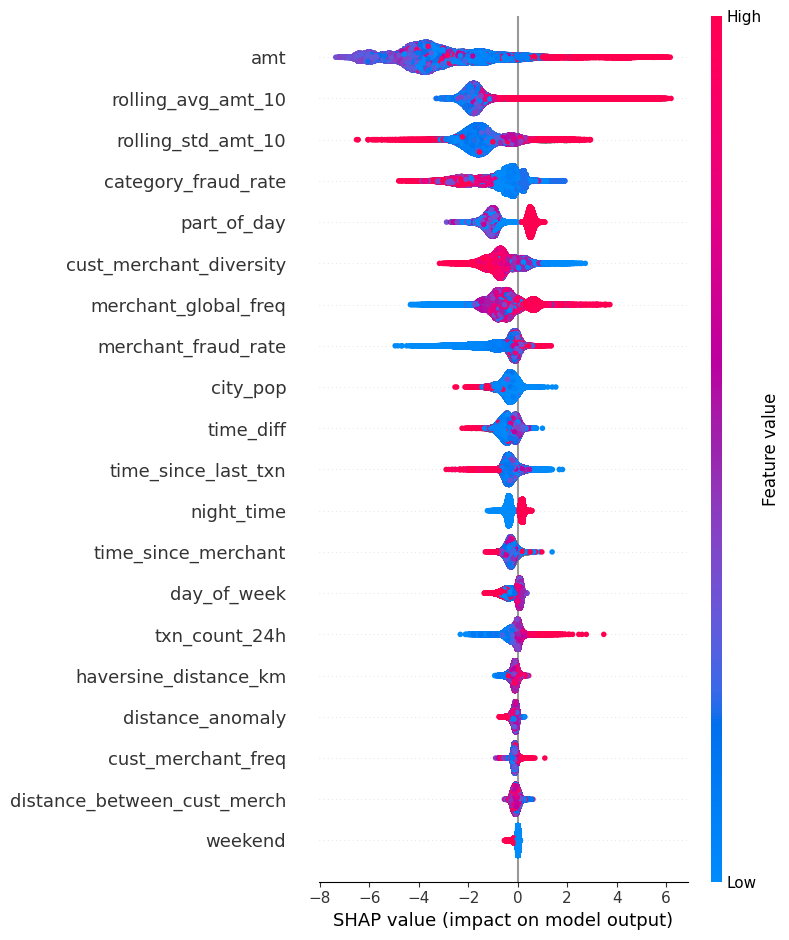

In [107]:
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, X_train)

SHAP confirmed that my model is learning meaningful fraud patterns. High transaction amounts, rolling volatility, and merchant‑level risk features consistently push predictions toward fraud. Geospatial deviation and velocity features also rank highly, showing that the model captures behavioral anomalies. I validated that the directionality aligns with domain expectations — for example, high merchant fraud rate and high transaction velocity increase fraud probability, while stable customer behavior reduces it.